## Importing Packages & Datasets

### Importing Packages

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.feature_selection import VarianceThreshold,RFE, mutual_info_classif, RFECV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix,accuracy_score, precision_score, recall_score, f1_score, make_scorer, precision_recall_curve
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import BaggingClassifier


### Importing Dataset

In [23]:
# CHANGE PATH
fold_1 = pd.read_csv('/Users/Sreenithi/Desktop/finalised_datasets/smote_train_data/fold_1.csv')
fold_2 = pd.read_csv('/Users/Sreenithi/Desktop/finalised_datasets/smote_train_data/fold_2.csv')
fold_3 = pd.read_csv('/Users/Sreenithi/Desktop/finalised_datasets/smote_train_data/fold_3.csv')
fold_4 = pd.read_csv('/Users/Sreenithi/Desktop/finalised_datasets/smote_train_data/fold_4.csv')
fold_5 = pd.read_csv('/Users/Sreenithi/Desktop/finalised_datasets/smote_train_data/fold_5.csv')
smote_fold_1 = pd.read_csv('/Users/Sreenithi/Desktop/finalised_datasets/smote_train_data/smote_fold_1.csv')
smote_fold_2 = pd.read_csv('/Users/Sreenithi/Desktop/finalised_datasets/smote_train_data/smote_fold_2.csv')
smote_fold_3 = pd.read_csv('/Users/Sreenithi/Desktop/finalised_datasets/smote_train_data/smote_fold_3.csv')
smote_fold_4 = pd.read_csv('/Users/Sreenithi/Desktop/finalised_datasets/smote_train_data/smote_fold_4.csv')
smote_fold_5 = pd.read_csv('/Users/Sreenithi/Desktop/finalised_datasets/smote_train_data/smote_fold_5.csv')

## Logistic Regression Model

We will proceed with this flow:

1. Logistic Regression Model Development
Train a logistic regression model on the preprocessed dataset, adjusting hyperparameters and exploring regularization techniques (e.g., L1 or L2) to prevent overfitting.

2. Model Evaluation
Evaluate the model's performance using utility fraud-specific metrics such as precision, recall, F1-score, AUC-ROC, and confusion matrix analysis.
Assess the balance between false positives and false negatives to minimize both missed fraud and unnecessary alerts.

### Preparing Data

In [24]:
training_data = pd.concat([smote_fold_1, smote_fold_2, smote_fold_3, smote_fold_4])
columns_drop = ['fraud_status', 'creation_year', 'creation_month', 'creation_day', 'months_number_mean', 'months_number_std', 'months_number_min', 'months_number_max', 'months_number_median', 'region_101','region_103', 'region_104', 'region_105', 'region_106', 'region_107',
                   'region_199', 'region_206', 'region_301', 'region_302', 'region_303',
                   'region_304', 'region_305', 'region_306', 'region_307', 'region_308',
                   'region_309', 'region_310', 'region_311', 'region_312', 'region_313',
                   'region_371', 'region_372', 'region_379', 'region_399', 'district_60',
                   'district_62', 'district_63', 'district_69', 'client_catg_11', 'client_catg_12',
                   'client_catg_51']
X_train = training_data.drop(columns=columns_drop)
y_train = training_data['fraud_status']
X_test = fold_5.drop(columns=columns_drop)
y_test = fold_5['fraud_status']

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

### Training Model

In [25]:
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [26]:
y_pred = log_reg.predict(X_test)

In [27]:
print(classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.99      0.56      0.72     20478
         1.0       0.10      0.87      0.19      1200

    accuracy                           0.58     21678
   macro avg       0.55      0.72      0.45     21678
weighted avg       0.94      0.58      0.69     21678

Confusion Matrix:
 [[11533  8945]
 [  151  1049]]
Accuracy: 0.5804040963188486


As seen from above, current model does not perform well and has very low accuracy.

## PCA

In [28]:
pca = PCA()
X_train_pca = pca.fit_transform(X_train)

### Plotting Cumulative Variance

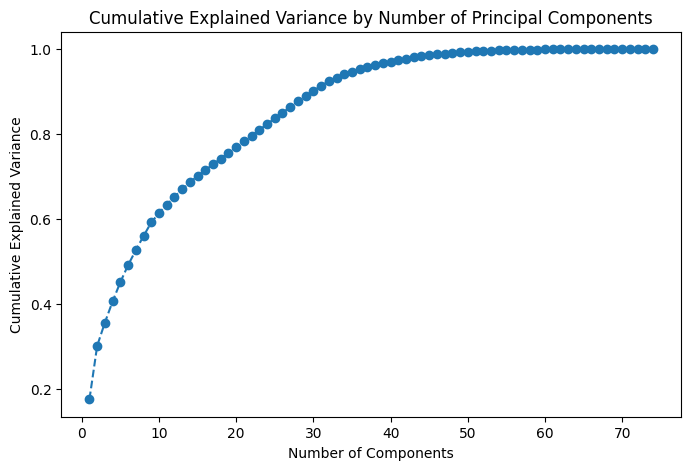

Number of components explaining 95% variance: 36


In [29]:
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1),
         pca.explained_variance_ratio_.cumsum(), marker='o', linestyle='--')
plt.title('Cumulative Explained Variance by Number of Principal Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.show()
n_components = np.argmax(pca.explained_variance_ratio_.cumsum() >= 0.95) + 1
print(f"Number of components explaining 95% variance: {n_components}")

In [30]:
pca = PCA(n_components=n_components)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.fit_transform(X_test)

In [31]:
log_reg = LogisticRegression()
log_reg.fit(X_train_pca, y_train)

LogisticRegression()

In [32]:
y_pred = log_reg.predict(X_test_pca)

In [33]:
print(classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.96      0.53      0.68     20478
         1.0       0.07      0.59      0.12      1200

    accuracy                           0.53     21678
   macro avg       0.51      0.56      0.40     21678
weighted avg       0.91      0.53      0.65     21678

Confusion Matrix:
 [[10813  9665]
 [  493   707]]
Accuracy: 0.5314143371159701


## RFE

In [34]:
scores = []

max_features = X_train.shape[1]
for n in range(1, max_features + 1): 
    rfe = RFE(estimator= LogisticRegression(max_iter=5000), n_features_to_select=n)
    X_train_rfe = rfe.fit_transform(X_train, y_train)
    score = np.mean(cross_val_score(LogisticRegression(max_iter=5000), X_train_rfe, y_train, cv=5))
    scores.append(score)

best_n_features = np.argmax(scores) + 1
print(f"Best number of features to select: {best_n_features}")

Best number of features to select: 59


In [43]:
rfe = RFE(estimator=LogisticRegression(), n_features_to_select= 36)
X_train_rfe = rfe.fit_transform(X_train_pca, y_train)
X_test_rfe = X_test_pca[:, rfe.support_] 

log_reg = LogisticRegression()
log_reg.fit(X_train_rfe, y_train)
y_pred = log_reg.predict(X_test_rfe)

In [44]:
print(classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.96      0.53      0.68     20478
         1.0       0.07      0.59      0.12      1200

    accuracy                           0.53     21678
   macro avg       0.51      0.56      0.40     21678
weighted avg       0.91      0.53      0.65     21678

Confusion Matrix:
 [[10813  9665]
 [  493   707]]
Accuracy: 0.5314143371159701


## GridSearchCV

### Finding best parameters

In [46]:
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'max_iter': [100, 500, 1000] 
}

log_reg = LogisticRegression()
grid_search = GridSearchCV(log_reg, param_grid, cv=5, scoring='recall', verbose=0)
grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sciki

KeyboardInterrupt: 

### Using Best Parameters

In [ ]:
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

In [ ]:
print(classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.99      0.56      0.71     20478
         1.0       0.10      0.88      0.19      1200

    accuracy                           0.58     21678
   macro avg       0.55      0.72      0.45     21678
weighted avg       0.94      0.58      0.69     21678

Confusion Matrix:
 [[11473  9005]
 [  144  1056]]
Accuracy: 0.577959221330381


## Adjusting Threshold

Best threshold for F1-score: 0.8430466667629364


/var/folders/nc/y24xw0zx141083cy3_vhwjw40000gn/T/ipykernel_23715/134292414.py:3: RuntimeWarning: invalid value encountered in divide
  f1_scores = np.where((precision + recall) == 0, 0, 2 * (precision * recall) / (precision + recall))


Text(0.5, 1.0, 'Precision-Recall Curve')

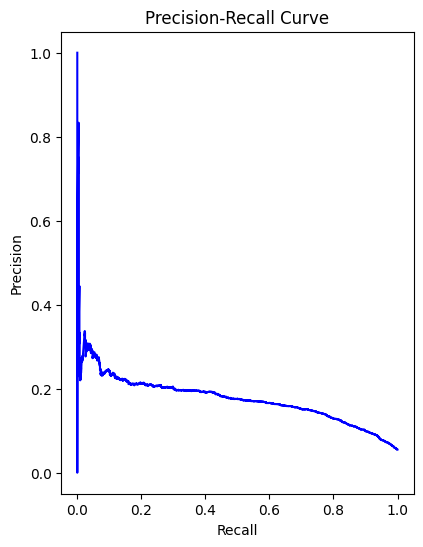

In [ ]:
y_prob = best_model.predict_proba(X_test)[:, 1]
precision, recall, threshold = precision_recall_curve(y_test, y_prob)
f1_scores = np.where((precision + recall) == 0, 0, 2 * (precision * recall) / (precision + recall))
best_threshold = threshold[np.argmax(f1_scores)]
print(f"Best threshold for F1-score: {best_threshold}")

plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.plot(recall, precision, color='blue')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')

In [ ]:
y_pred_best_threshold = (y_prob >= best_threshold).astype(int)
print(classification_report(y_test, y_pred_best_threshold))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_best_threshold))
print("Accuracy:", accuracy_score(y_test, y_pred_best_threshold))

              precision    recall  f1-score   support

         0.0       0.96      0.89      0.93     20478
         1.0       0.19      0.43      0.26      1200

    accuracy                           0.87     21678
   macro avg       0.58      0.66      0.60     21678
weighted avg       0.92      0.87      0.89     21678

Confusion Matrix:
 [[18291  2187]
 [  684   516]]
Accuracy: 0.8675615831718794


## K-Folds Cross Validation

In [ ]:
folds = [fold_1, fold_2, fold_3, fold_4, fold_5]
smotes = [smote_fold_1, smote_fold_2, smote_fold_3, smote_fold_4, smote_fold_5]

for i in range(len(folds)):
    test_fold = folds[i]
    train_folds = [fold for j, fold in enumerate(smotes) if j != i]
    X_train = pd.concat([fold.drop(columns=columns_drop) for fold in train_folds], axis=0)
    y_train = pd.concat([fold['fraud_status'] for fold in train_folds], axis=0)
    X_test = test_fold.drop(columns=columns_drop)
    y_test = test_fold['fraud_status']

    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    best_model.fit(X_train_scaled, y_train)
    y_pred = best_model.predict(X_test_scaled)
    y_pred_best_threshold = (y_pred >= best_threshold).astype(int)
    print(f"Classification Report for fold {i + 1}:\n", classification_report(y_test, y_pred_best_threshold))
    print(f"Confusion Matrix for fold {i + 1}:\n", confusion_matrix(y_test, y_pred_best_threshold))
    print(f"Accuracy for fold {i + 1}: {accuracy_score(y_test, y_pred_best_threshold):.4f}")
    print("-" * 50)


Classification Report for fold 1:
               precision    recall  f1-score   support

         0.0       0.98      0.77      0.86     20479
         1.0       0.15      0.70      0.25      1200

    accuracy                           0.77     21679
   macro avg       0.57      0.74      0.56     21679
weighted avg       0.93      0.77      0.83     21679

Confusion Matrix for fold 1:
 [[15854  4625]
 [  354   846]]
Accuracy for fold 1: 0.7703
--------------------------------------------------
Classification Report for fold 2:
               precision    recall  f1-score   support

         0.0       0.98      0.77      0.86     20479
         1.0       0.15      0.72      0.25      1200

    accuracy                           0.77     21679
   macro avg       0.57      0.74      0.56     21679
weighted avg       0.93      0.77      0.83     21679

Confusion Matrix for fold 2:
 [[15724  4755]
 [  334   866]]
Accuracy for fold 2: 0.7653
-----------------------------------------------